Necessary imports

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import time

Importing datasets 1 and 2

In [2]:
pip install ucimlrepo

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.3.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [ ]:
from ucimlrepo import fetch_ucirepo

# Dataset 1. 5875 instances.
parkinsons_telemonitoring = fetch_ucirepo(id=189)

# Extract features. There are 19 features actually (+ subject# for ID), but we will only be using 16 of them (the biomedical voice measures).
X_1 = parkinsons_telemonitoring.data.features
X_1.drop(columns=['age', 'test_time', 'sex'], inplace=True)
# Put features in dictionary of lists
X_1 = { col: X_1[col].to_list() for col in X_1 }

# Extract targets. We are aiming to predict motor_UPDRS.
y_1 = parkinsons_telemonitoring.data.targets
y_1 = y_1['motor_UPDRS'].to_list()


# Dataset 2. 569 instances.
breast_cancer_wisconsin = fetch_ucirepo(id=17)

# Extract features. There are 30 features.
X_2 = breast_cancer_wisconsin.data.features
X_2 = { col: X_2[col].to_list() for col in X_2 }

# Extract the targets. We are aiming to predict between Malignant (M) or Benign (B) classes.
y_2 = breast_cancer_wisconsin.data.targets
y_2 = y_2['Diagnosis'].to_list()


C:\Users\Steve\AppData\Local\Temp\ipykernel_8368\2507659700.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_1.drop(columns=['age', 'test_time', 'sex'], inplace=True)


Visualization of datasets 1 and 2

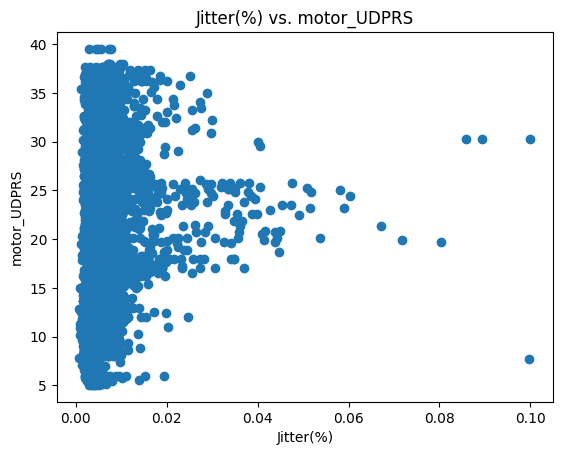

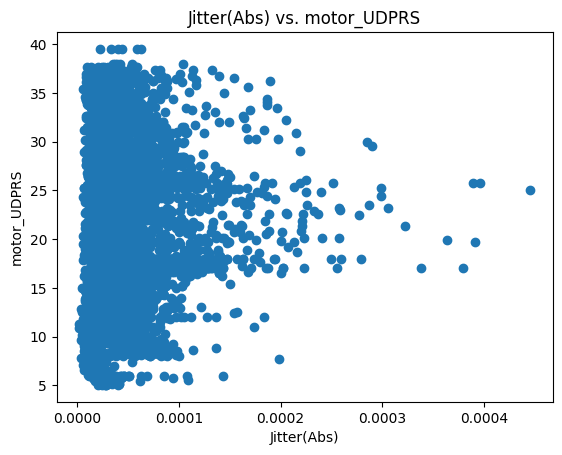

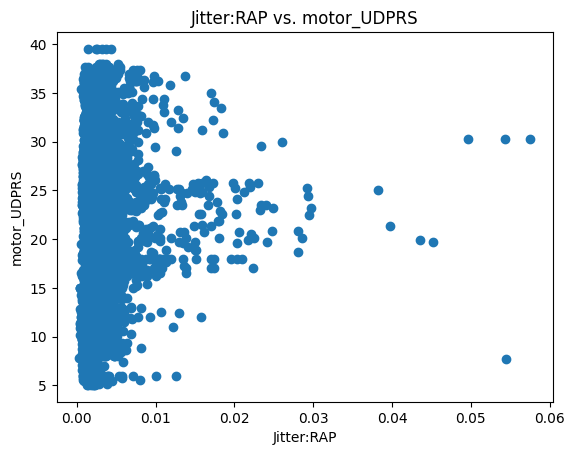

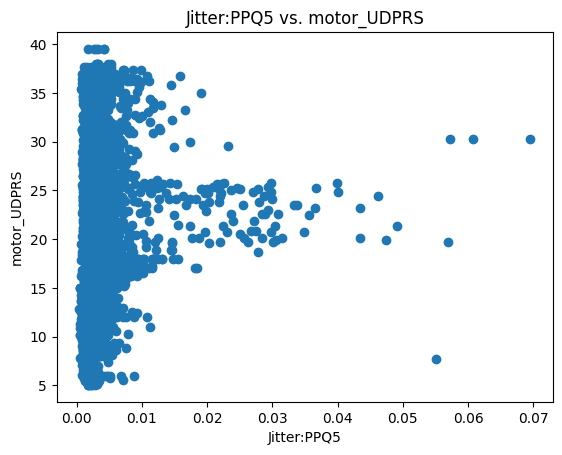

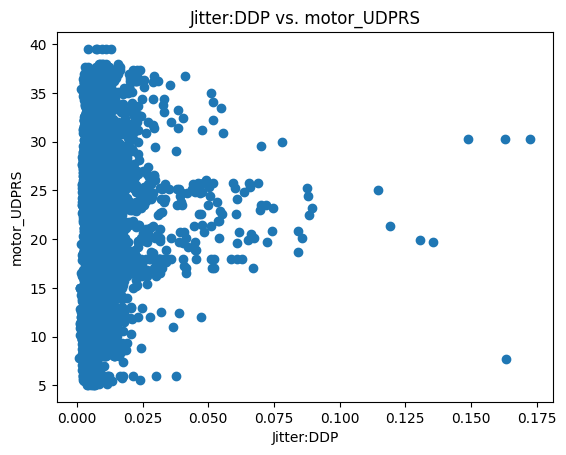

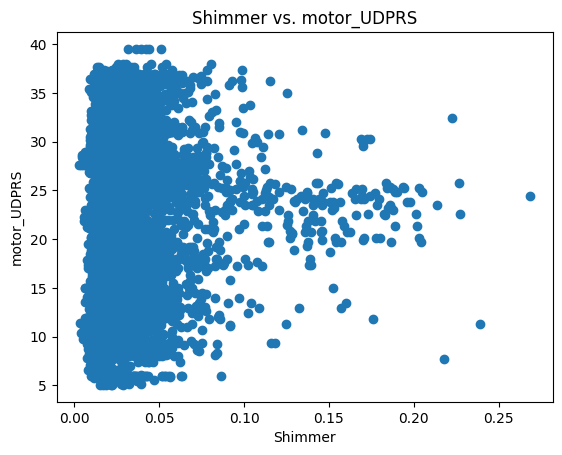

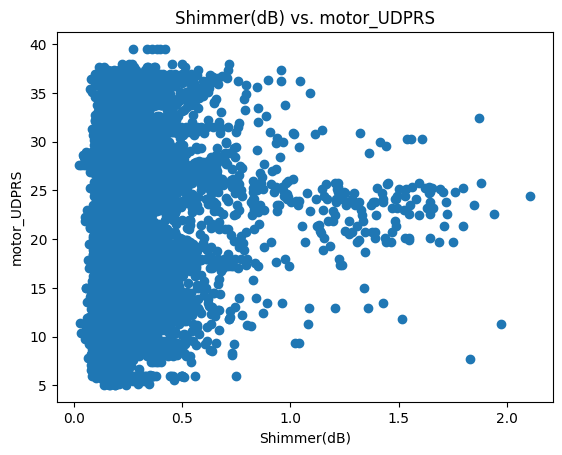

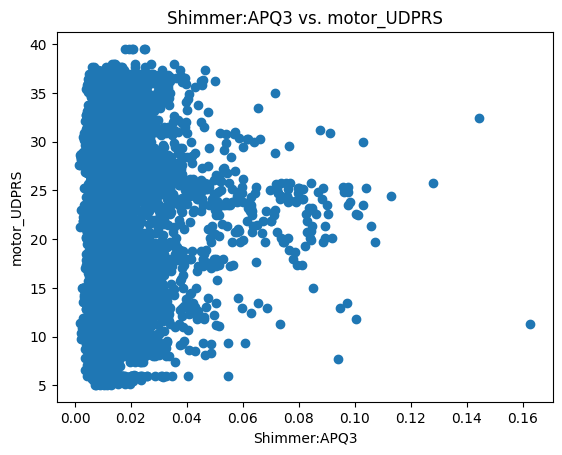

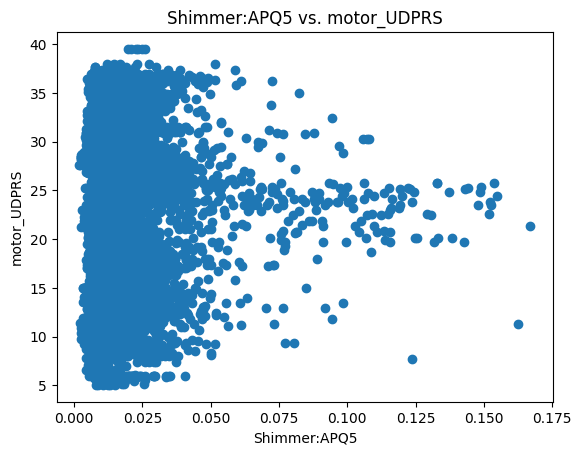

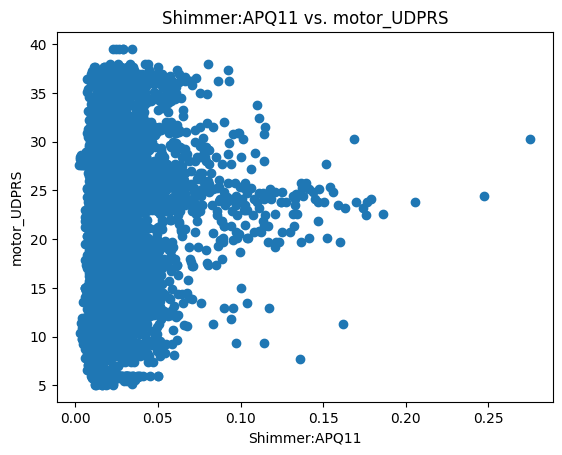

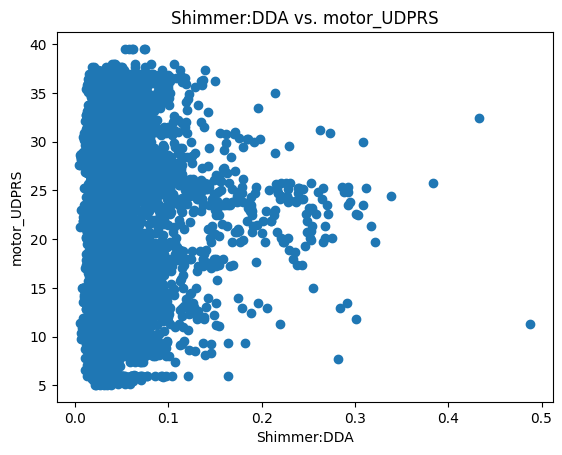

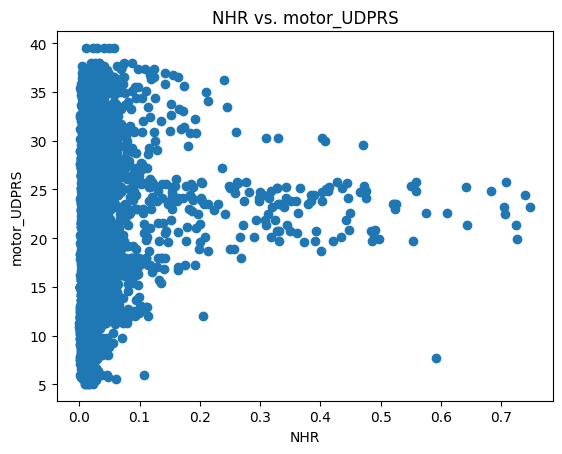

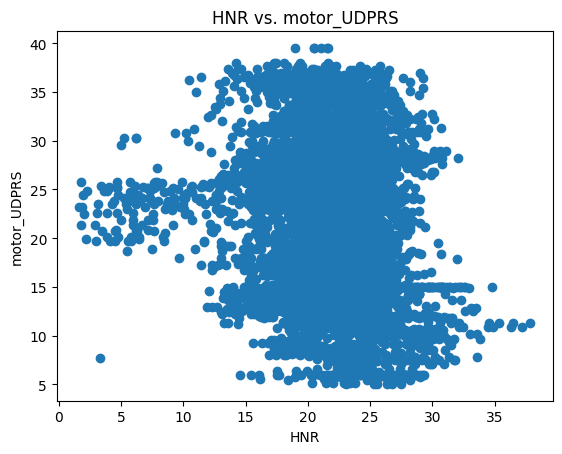

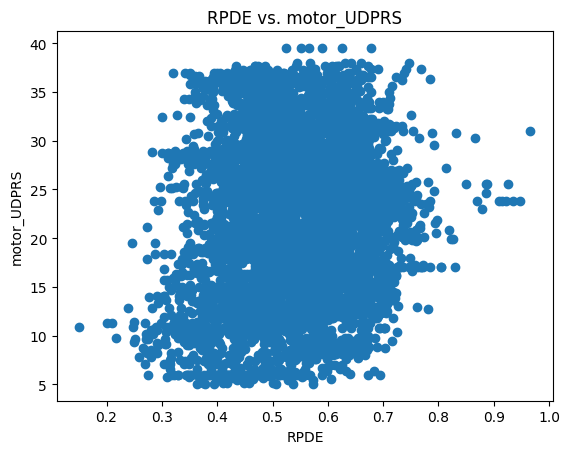

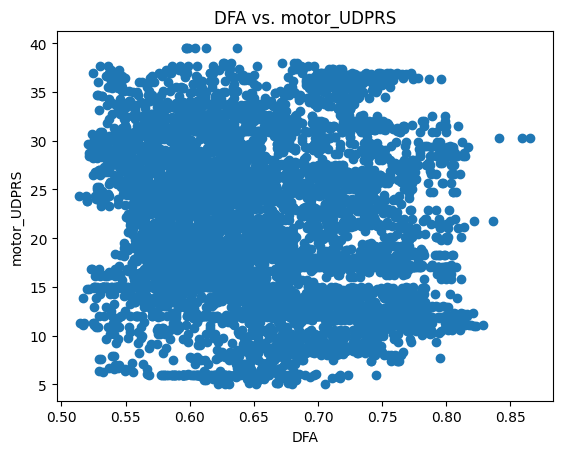

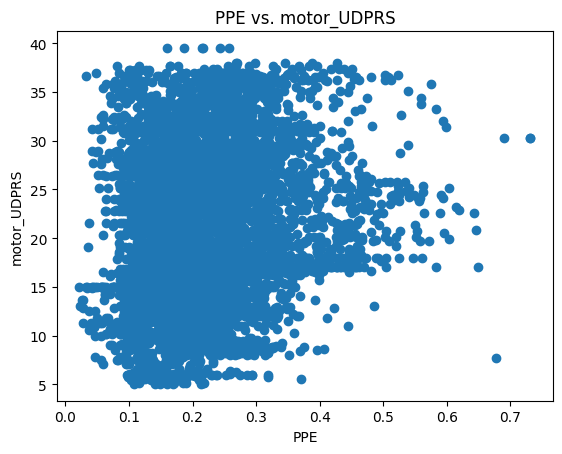

In [4]:
feature_labels = ['Jitter(%)', 'Jitter(Abs)', 'Jitter:RAP',
       'Jitter:PPQ5', 'Jitter:DDP', 'Shimmer', 'Shimmer(dB)', 'Shimmer:APQ3',
       'Shimmer:APQ5', 'Shimmer:APQ11', 'Shimmer:DDA', 'NHR', 'HNR', 'RPDE',
       'DFA', 'PPE']

# For each feature, we will graph it against the target. Meaning we will have 19 graphs!
for label in feature_labels:
    plt.scatter(X_1[label], y_1)
    plt.title(label + " vs. motor_UDPRS")
    plt.ylabel("motor_UDPRS")
    plt.xlabel(label)
    plt.show()

motor_UPDRS is a score given after putting patients through a clinical test where each part has a rating. The ratings then get summed up to get the motor_UPDRS score. The higher the score, the worse the motor impairement becomes. The majority of these graphs depict varying ranges of motor_UPDRS scores with a lot fo them peaking at around the middle of the scale. Instances gathering around a clear range of feature values will prove to weaken the robustness and accuracy of our regression model, but the occasional peaks will serve us good for predicting most motor test scores.

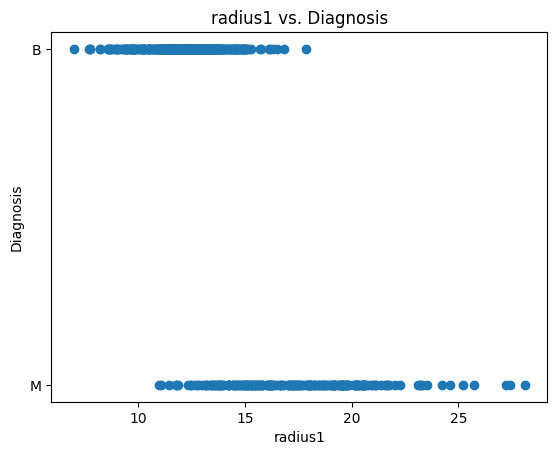

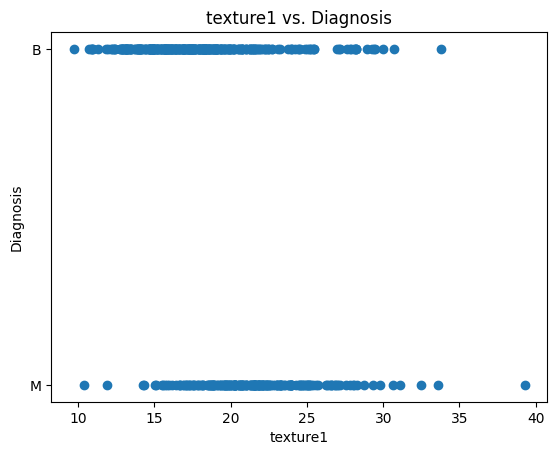

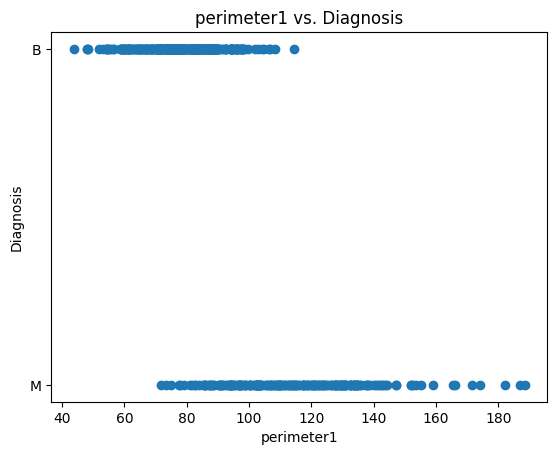

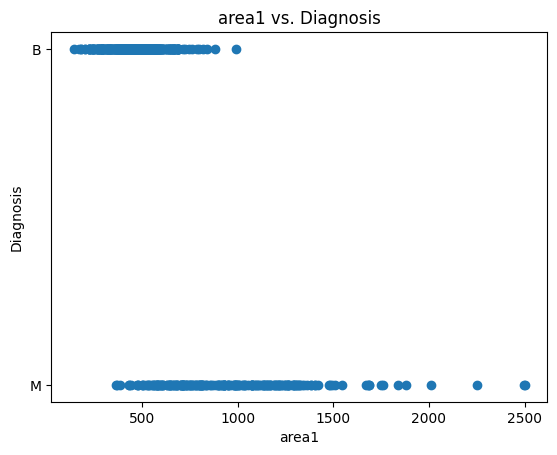

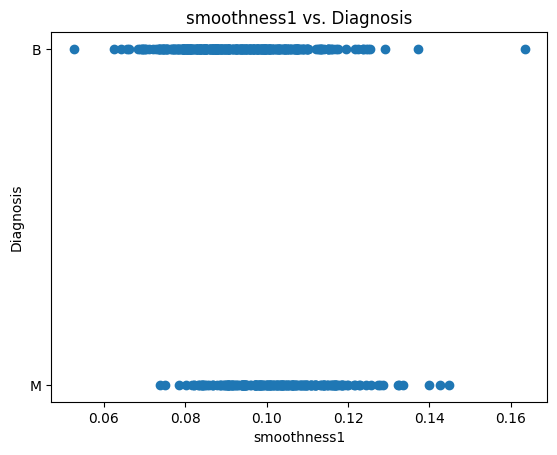

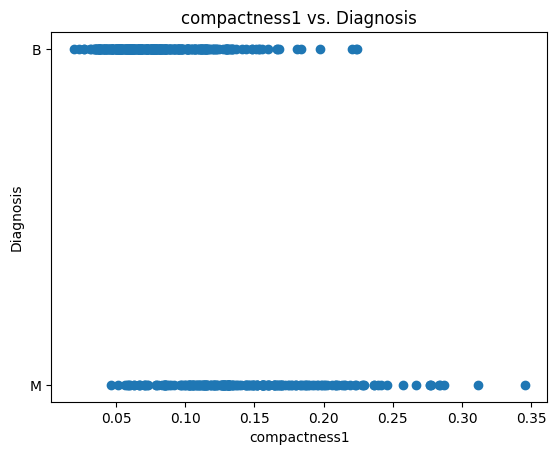

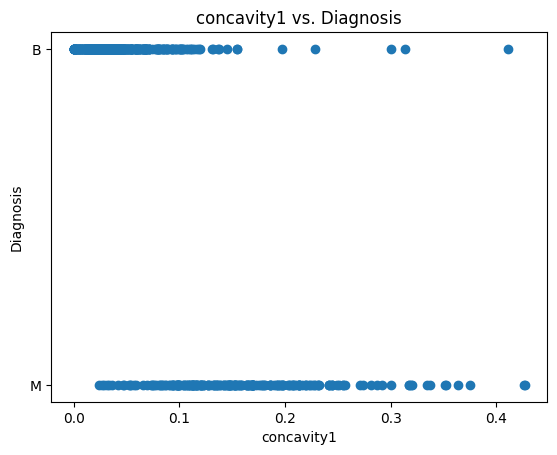

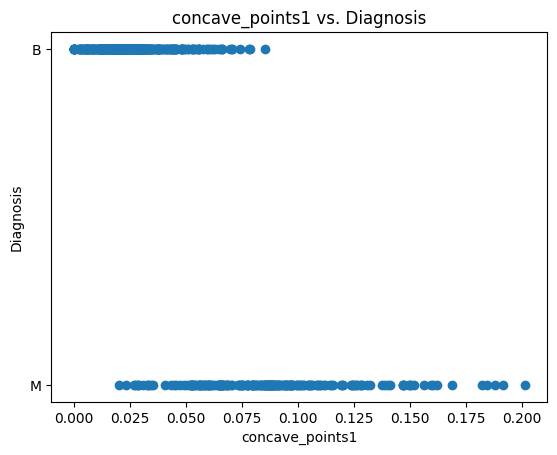

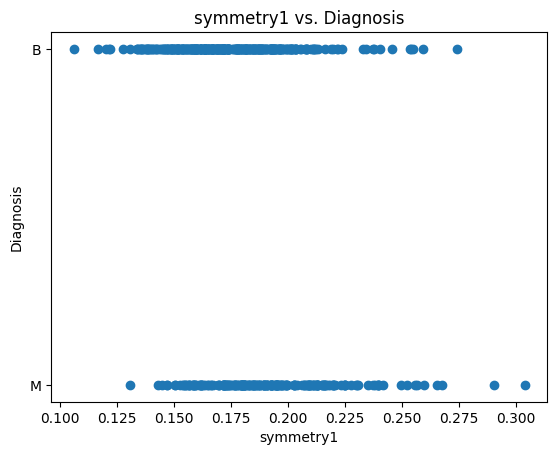

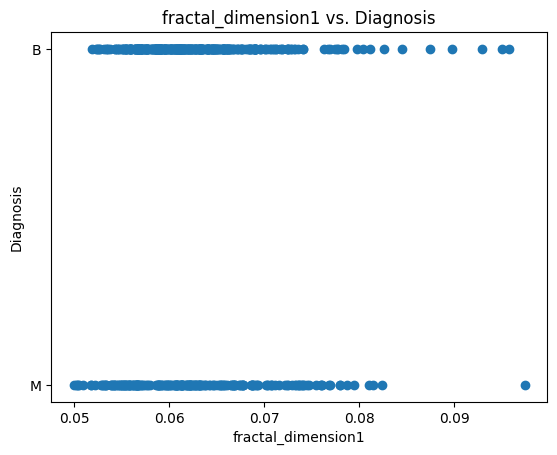

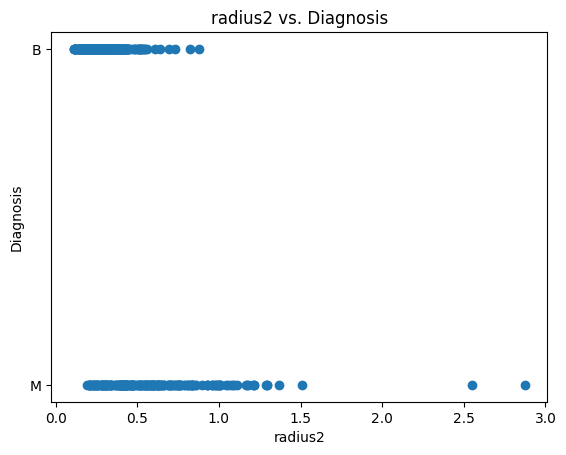

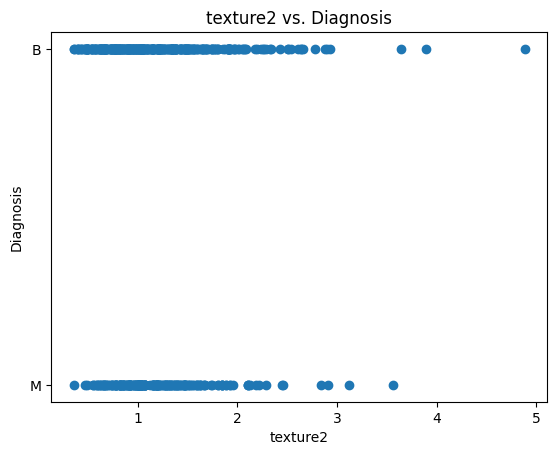

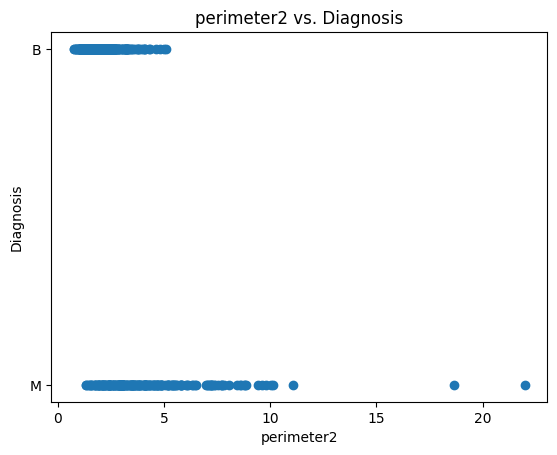

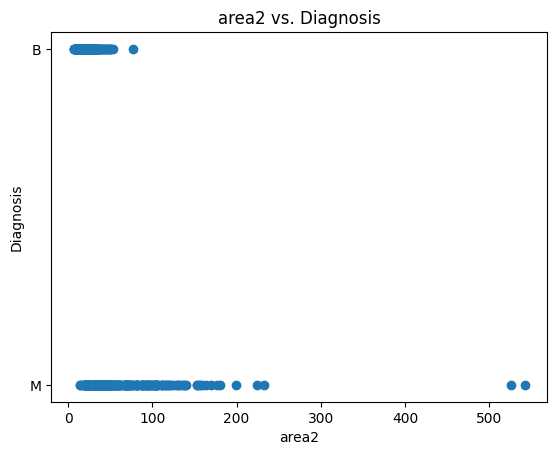

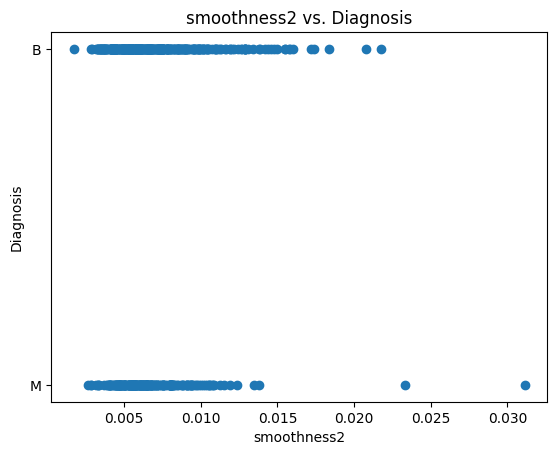

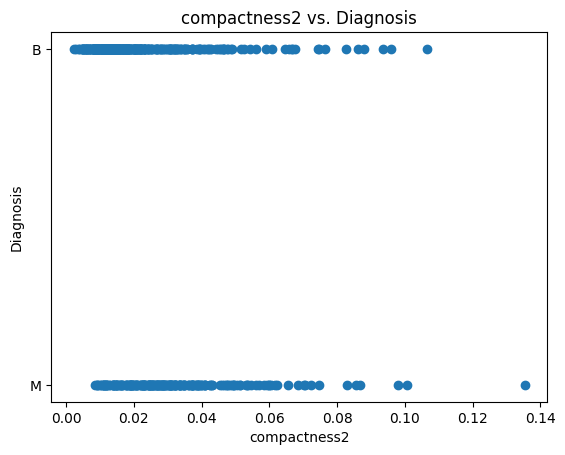

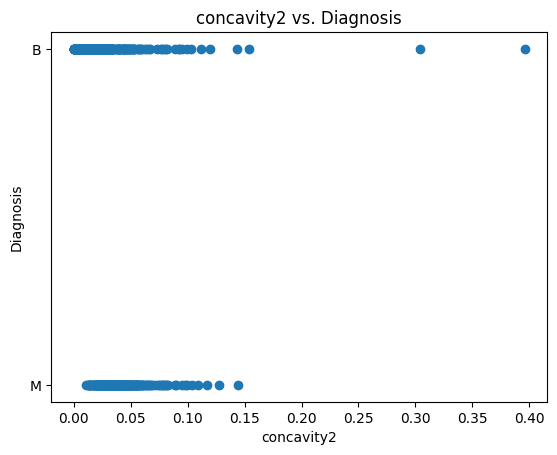

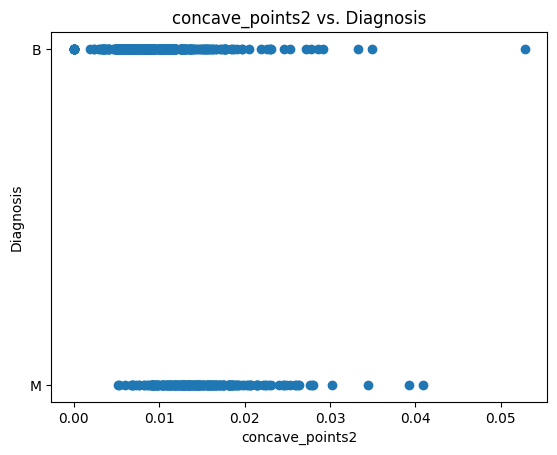

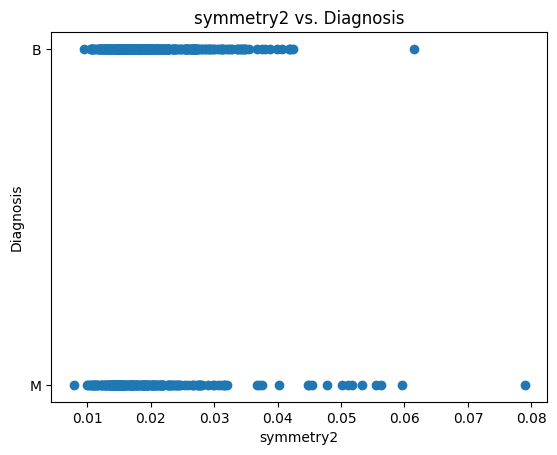

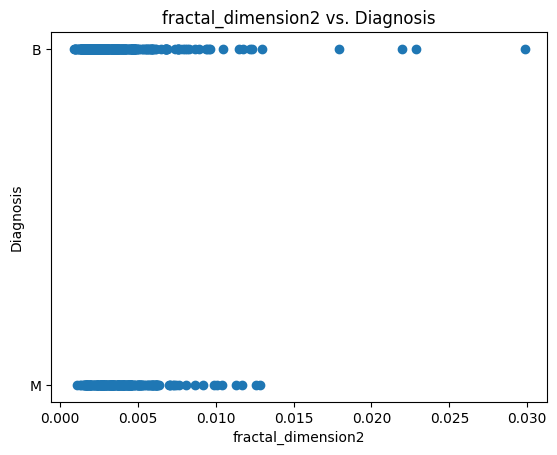

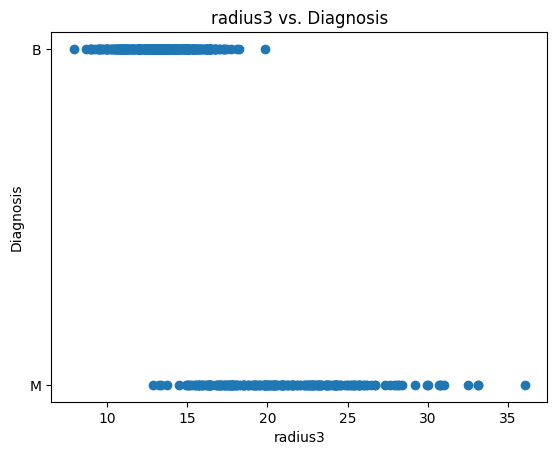

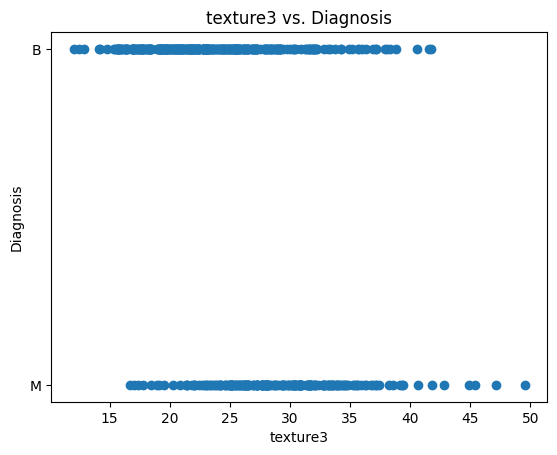

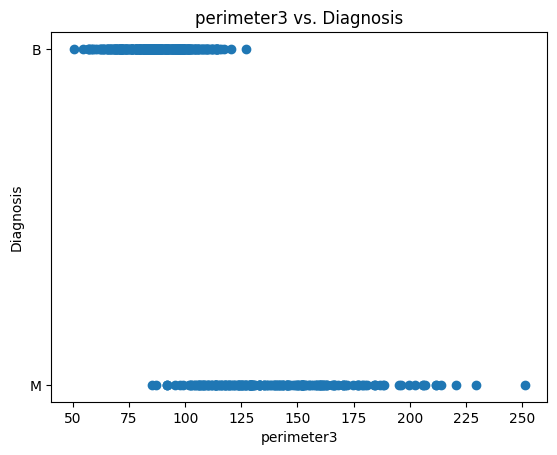

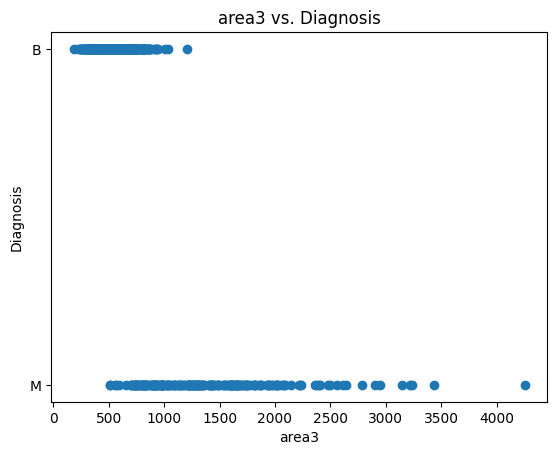

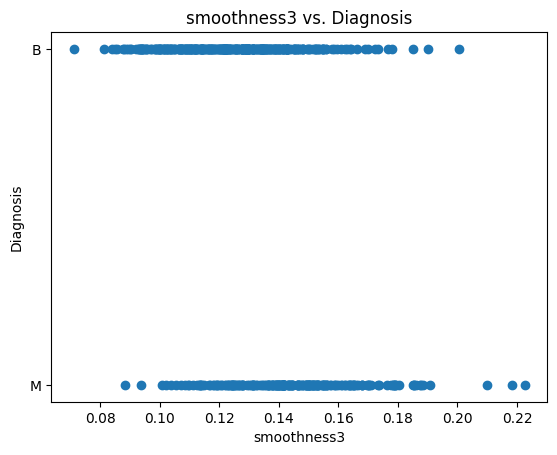

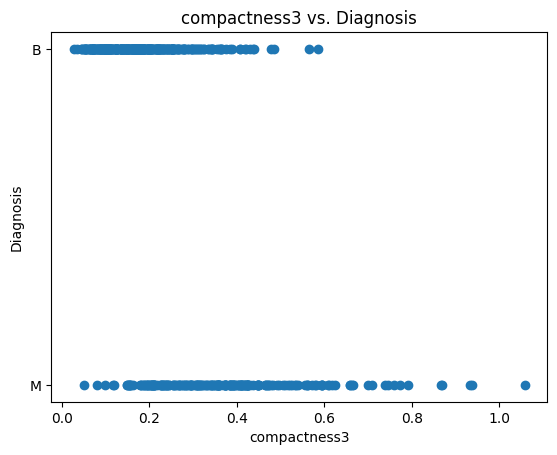

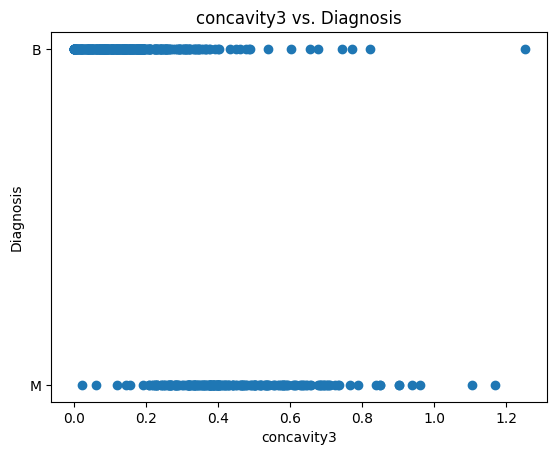

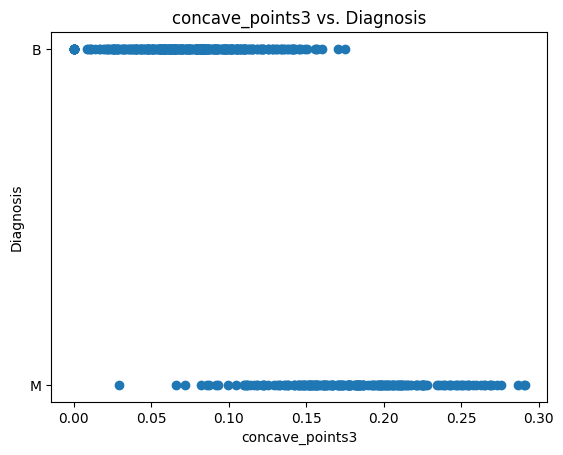

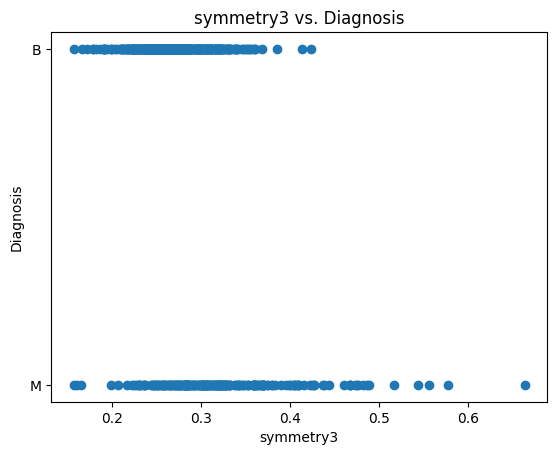

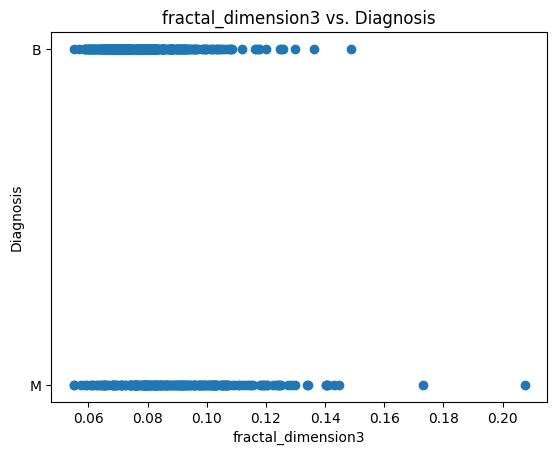

In [5]:
feature_labels = ['radius1', 'texture1', 'perimeter1', 'area1', 'smoothness1',
       'compactness1', 'concavity1', 'concave_points1', 'symmetry1',
       'fractal_dimension1', 'radius2', 'texture2', 'perimeter2', 'area2',
       'smoothness2', 'compactness2', 'concavity2', 'concave_points2',
       'symmetry2', 'fractal_dimension2', 'radius3', 'texture3', 'perimeter3',
       'area3', 'smoothness3', 'compactness3', 'concavity3', 'concave_points3',
       'symmetry3', 'fractal_dimension3']

# For each feature, we will graph it against the target. Meaning we will have 30 graphs!
# We let Benign = 0, Malignant = 1
for label in feature_labels:
    plt.scatter(X_2[label], y_2)
    plt.title(label + " vs. Diagnosis")
    plt.ylabel("Diagnosis")
    plt.xlabel(label)
    plt.show()

In some cases, we notice distinct ranges in feature values which translate to an easier prediction of the diagnosis, like for radius1, where a smaller radius typically means a benign tumour. Other features, like fractal_dimension3 offer little information about the resulting tumour, which may indicate that its resulting weight may be much smaller than radius1, for example. We would even go further by stating that the mean of each diagnosis group either overlap (or are very close) or are distinctly separate. For the means that are distinctly separate, we expect higher weight values. The inverse should be observed with overlapping means (i.e. 0 or close to 0 weights).

Data Preprocessing:

In [6]:
# Dataset 1 preprocessing
feature_order_1 = list(X_1.keys())  # keep column order stable
X1_mat = np.column_stack([np.asarray(X_1[c]) for c in feature_order_1]) # 2D array where each row is one patient/sample and each column is one feature
y1_vec = np.asarray(y_1, dtype=float) # 1D array of the target variable for each sample

In [7]:
# Dataset 2 preprocessing
feature_order_2 = list(X_2.keys())
X2_mat = np.column_stack([np.asarray(X_2[c]) for c in feature_order_2])

# map labels to 0/1 floats
y2_vec = np.array([1.0 if v == 'M' else 0.0 for v in y_2], dtype=float)

In [9]:
# check arrays
for name in ["X1_mat", "y1_vec", "X2_mat", "y2_vec"]:
    if name not in globals():
        raise NameError(f"{name} is not defined. Make sure you added the prep cells for arrays.")

print("X1_mat:", type(X1_mat), X1_mat.shape)
print("y1_vec:", type(y1_vec), y1_vec.shape, "dtype:", y1_vec.dtype)
print("X2_mat:", type(X2_mat), X2_mat.shape)
print("y2_vec:", type(y2_vec), y2_vec.shape, "dtype:", y2_vec.dtype)

X1_mat: <class 'numpy.ndarray'> (5875, 16)
y1_vec: <class 'numpy.ndarray'> (5875,) dtype: float64
X2_mat: <class 'numpy.ndarray'> (569, 30)
y2_vec: <class 'numpy.ndarray'> (569,) dtype: float64


Model and helpers definitions

Linear regression:

In [10]:
class LinearRegression:
  def __init__(self, lr=0.01, epochs=1000, batch_size=32):
    self.weights = None
    self.lr = lr
    self.batch_size = batch_size
    self.epochs = epochs

  def fit(self, X, y):
    X_b = np.c_[np.ones((X.shape[0], 1)), X] # add x_0 column of 1s
    self.weights = np.linalg.inv(X_b.T @ X_b) @ X_b.T @ y # perform matrix operation to get weights

  def predict(self, X):
    X_b = np.c_[np.ones((X.shape[0], 1)), X] # add bias column
    return X_b @ self.weights # dot product row*weights

  def fit_sgd(self, X, y, lr=None, epochs=None, batch_size=None, seed=0, return_history=False): #stochastic gradient descent
    lr = self.lr if lr is None else lr
    epochs = self.epochs if epochs is None else epochs
    batch = self.batch_size if batch_size is None else batch_size

    n = X.shape[0]
    X_b = np.c_[np.ones((n, 1)), X]
    self.weights = np.zeros(X_b.shape[1])
    rng = np.random.default_rng(seed)
    history = []

    for _ in range(epochs):
        idx = rng.permutation(n)
        Xb = X_b[idx]
        yb = y[idx]

        if batch == "full" or (isinstance(batch, int) and batch >= n):
            starts, ends = [0], [n]
        else:
            starts = list(range(0, n, batch))
            ends = [min(s + batch, n) for s in starts]

        for s, e in zip(starts, ends):
            X_batch = Xb[s:e]
            y_batch = yb[s:e]
            y_hat = X_batch @ self.weights
            grad = (X_batch.T @ (y_hat - y_batch)) / len(y_batch)
            self.weights -= lr * grad

        if return_history:
            y_hat_full = X_b @ self.weights
            history.append(float(np.mean((y - y_hat_full) ** 2)))

    return (self, np.array(history)) if return_history else self

Logistic regression:

In [11]:
class LogisticRegressionGD:
  def __init__(self, lr=0.01, epochs=1000, batch_size=32):
    self.lr = lr
    self.weights = None
    self.batch_size = batch_size
    self.epochs = epochs

  def sigmoid(self, x):
    return 1/(1+np.exp(-x))

  def fit(self, X, y):
    sample_count, feature_count = X.shape
    X_b = np.c_[np.ones((sample_count, 1)), X]
    self.weights = np.zeros(feature_count + 1) # initialize weights to 0

    for i in range(self.epochs):
      y_hat = self.sigmoid(X_b @ self.weights) # get expected probability
      #get gradient
      gradient = (X_b.T @ (y_hat - y)) / sample_count
      #update
      self.weights -= self.lr * gradient

  def predict(self, X):
    X_b = np.c_[np.ones((X.shape[0], 1)), X]
    return (self.sigmoid(X_b @ self.weights) >= 0.5).astype(int)

  def fit_sgd(self, X, y, lr=None, epochs=None, batch_size=None, seed=0, return_history=False):
        lr = self.lr if lr is None else lr
        epochs = self.epochs if epochs is None else epochs
        batch = self.batch_size if batch_size is None else batch_size

        n = X.shape[0]
        X_b = np.c_[np.ones((n, 1)), X]
        self.weights = np.zeros(X_b.shape[1])
        rng = np.random.default_rng(seed)
        history = []
        eps = 1e-12

        for _ in range(epochs):
            idx = rng.permutation(n)
            Xb = X_b[idx]; yb = y[idx]

            if batch == "full" or (isinstance(batch, int) and batch >= n):
                starts, ends = [0], [n]
            else:
                starts = list(range(0, n, batch))
                ends = [min(s + batch, n) for s in starts]

            for s, e in zip(starts, ends):
                X_batch = Xb[s:e]; y_batch = yb[s:e]
                p = self.sigmoid(X_batch @ self.weights)
                grad = (X_batch.T @ (p - y_batch)) / len(y_batch)
                self.weights -= lr * grad

            if return_history:
                p_full = np.clip(self.sigmoid(X_b @ self.weights), eps, 1 - eps)
                logloss = -np.mean(y * np.log(p_full) + (1 - y) * np.log(1 - p_full))
                history.append(float(logloss))

        return (self, np.array(history)) if return_history else self

Helpers:

In [12]:
def train_test_split_80_20(X, y, seed=42):
    rng = np.random.default_rng(seed)
    m = X.shape[0]
    idx = rng.permutation(m)
    cut = int(0.8 * m)
    tr, te = idx[:cut], idx[cut:]
    return X[tr], X[te], y[tr], y[te]

def standardize_train_test(Xtr, Xte):
    # zero-mean / unit-std using train stats only
    mu = Xtr.mean(axis=0)
    sigma = Xtr.std(axis=0)
    sigma[sigma == 0] = 1.0  # avoid divide-by-zero if a feature is constant
    return (Xtr - mu) / sigma, (Xte - mu) / sigma

def mse(y_true, y_pred):
    y_true = y_true.reshape(-1)
    y_pred = y_pred.reshape(-1)
    return float(np.mean((y_pred - y_true) ** 2))

def accuracy(y_true, y_pred_binary):
    y_true = y_true.reshape(-1)
    y_pred_binary = y_pred_binary.reshape(-1)
    return float(np.mean(y_true == y_pred_binary))

Part 3.1 - Dataset 1: linear regression with closed-form solution

In [13]:
# split dataset 1 into 80% training and 20% testing
features_train, features_test, targets_train, targets_test = train_test_split_80_20(X1_mat, y1_vec, seed=0)

linear_model = LinearRegression()
linear_model.fit(features_train, targets_train)

# make predictions on train and test sets
targets_train_predicted = linear_model.predict(features_train)
targets_test_predicted = linear_model.predict(features_test)

print("dataset 1 linear regression (analytical) - mse train:", round(mse(targets_train, targets_train_predicted), 4))
print("dataset 1 linear regression (analytical) - mse test :", round(mse(targets_test, targets_test_predicted), 4))

dataset 1 linear regression (analytical) - mse train: 58.6705
dataset 1 linear regression (analytical) - mse test : 61.2742


Part 3.1 - Dataset 2: logistic regression with fully batched gradient descent

In [14]:
# split dataset 2 into 80% training and 20% testing
features_train_d2, features_test_d2, targets_train_d2, targets_test_d2 = train_test_split_80_20(X2_mat, y2_vec, seed=0)

# standardize features (helps gradient descent converge; uses only train stats)
features_train_d2_std, features_test_d2_std = standardize_train_test(features_train_d2, features_test_d2)

logistic_model_fullbatch = LogisticRegressionGD(lr=0.1, epochs=300, batch_size=32)

# train on the standardized training features
logistic_model_fullbatch.fit(features_train_d2_std, targets_train_d2)

# make predictions (0/1) on train and test sets
targets_train_predicted_d2 = logistic_model_fullbatch.predict(features_train_d2_std)
targets_test_predicted_d2 = logistic_model_fullbatch.predict(features_test_d2_std)

print("dataset 2 logistic regression (full-batch) - accuracy train:", round(accuracy(targets_train_d2, targets_train_predicted_d2), 4))
print("dataset 2 logistic regression (full-batch) - accuracy test :", round(accuracy(targets_test_d2,  targets_test_predicted_d2), 4))

dataset 2 logistic regression (full-batch) - accuracy train: 0.9868
dataset 2 logistic regression (full-batch) - accuracy test : 0.9561


Part 3.2 - Dataset 1: Weights (linear regression with closed form solution)

In [15]:
# the first weight is the intercept (bias) because we added a column of 1s inside the model
intercept_d1 = float(linear_model.weights[0])
weights_d1 = linear_model.weights[1:]  # one weight per feature

# pair feature names with weights using the same order used to build X1_mat
weights_table_d1 = pd.Series(weights_d1, index=feature_order_1, name="weight")

print("dataset 1 - intercept (bias):", round(intercept_d1, 6))
print("\ndataset 1 - top 10 features by absolute weight (strongest influence):")
display(weights_table_d1.reindex(weights_table_d1.abs().sort_values(ascending=False).index).head(10))

print("\ndataset 1 - top 10 positive weights (increase target when feature increases):")
display(weights_table_d1.sort_values(ascending=False).head(10))

print("\ndataset 1 - top 10 negative weights (decrease target when feature increases):")
display(weights_table_d1.sort_values(ascending=True).head(10))

dataset 1 - intercept (bias): 45.556834

dataset 1 - top 10 features by absolute weight (strongest influence):


Jitter(Abs)     -54022.809240
Jitter:RAP      -31539.713646
Jitter:DDP       10605.220591
Shimmer:APQ3     -3878.273253
Shimmer:DDA       1251.161776
Shimmer:APQ5      -243.273964
Jitter(%)          151.198116
Shimmer:APQ11      148.697495
Shimmer            126.048493
Jitter:PPQ5        100.279781
Name: weight, dtype: float64


dataset 1 - top 10 positive weights (increase target when feature increases):


Jitter:DDP       10605.220591
Shimmer:DDA       1251.161776
Jitter(%)          151.198116
Shimmer:APQ11      148.697495
Shimmer            126.048493
Jitter:PPQ5        100.279781
PPE                 19.250856
RPDE                 0.443245
HNR                 -0.424450
Shimmer(dB)         -2.817814
Name: weight, dtype: float64


dataset 1 - top 10 negative weights (decrease target when feature increases):


Jitter(Abs)    -54022.809240
Jitter:RAP     -31539.713646
Shimmer:APQ3    -3878.273253
Shimmer:APQ5     -243.273964
NHR               -29.175656
DFA               -28.829083
Shimmer(dB)        -2.817814
HNR                -0.424450
RPDE                0.443245
PPE                19.250856
Name: weight, dtype: float64

*   Jitter/shimmer features dominate → the model strongly relies on voice irregularity measures, which makes sense medically.
*   Many jitter/shimmer features are correlated → this can cause unstable weights (very large positive/negative numbers) that may hurt generalization.
*   Age/test_time have small weights → little influence on predictions, so dropping them would not change performance much.
*   Overall: model performance is reasonable, but sensitivity to correlated features may limit robustness.

Part 3.2 - Dataset 2: Weights (logistic regression with full-batch gd)

In [16]:
# note: we trained logistic on standardized features, so magnitudes are comparable across features,
# but the intercept reflects that standardization. signs still interpret the same way
intercept_d2 = float(logistic_model_fullbatch.weights[0])
weights_d2 = logistic_model_fullbatch.weights[1:]  # one weight per feature

weights_table_d2 = pd.Series(weights_d2, index=feature_order_2, name="weight")

print("dataset 2 - intercept (bias):", round(intercept_d2, 6))
print("\ndataset 2 - top 10 features by absolute weight (strongest influence on probability of malignant=1):")
display(weights_table_d2.reindex(weights_table_d2.abs().sort_values(ascending=False).index).head(10))

print("\ndataset 2 - top 10 positive weights (increase probability of malignant=1):")
display(weights_table_d2.sort_values(ascending=False).head(10))

print("\ndataset 2 - top 10 negative weights (decrease probability of malignant=1):")
display(weights_table_d2.sort_values(ascending=True).head(10))

dataset 2 - intercept (bias): -0.558822

dataset 2 - top 10 features by absolute weight (strongest influence on probability of malignant=1):


texture3           0.638094
radius3            0.626967
area3              0.609820
perimeter3         0.599590
radius2            0.583438
concave_points3    0.547129
concave_points1    0.542509
texture1           0.516008
smoothness3        0.503896
area1              0.501992
Name: weight, dtype: float64


dataset 2 - top 10 positive weights (increase probability of malignant=1):


texture3           0.638094
radius3            0.626967
area3              0.609820
perimeter3         0.599590
radius2            0.583438
concave_points3    0.547129
concave_points1    0.542509
texture1           0.516008
smoothness3        0.503896
area1              0.501992
Name: weight, dtype: float64


dataset 2 - top 10 negative weights (decrease probability of malignant=1):


fractal_dimension1   -0.303404
fractal_dimension2   -0.263464
compactness2         -0.228651
symmetry2            -0.186450
concavity2           -0.083579
symmetry1             0.008997
texture2              0.025409
compactness1          0.036833
concave_points2       0.074981
smoothness2           0.090984
Name: weight, dtype: float64

*   Size/shape features (radius, area, perimeter) and texture contribute most → larger values increase malignant probability.
*   Negative weights on fractal dimension → higher values lean benign.
*   Features are correlated (radius, area, perimeter), which can make weights unstable, but accuracy remains high (~96%).
*   Standardization helped training converge and made coefficients comparable, improving stability.

Part 3.3: Setup

In [17]:
training_size_fractions = [0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8]

# how many independent repeats per training size (for error bars)
repeats_per_size = 50

# base random seed (keeps results reproducible but different across repeats)
base_random_seed = 123

# helper to get a rng for a given (fraction_index, repeat_index)
def make_rng(fraction_index: int, repeat_index: int) -> np.random.Generator:
    # create a distinct, reproducible seed per (fraction, repeat)
    combined_seed = base_random_seed + 1000 * fraction_index + repeat_index
    return np.random.default_rng(combined_seed)

# helper to draw a subset of given size from indices without replacement
def sample_indices(total_count: int, subset_count: int, rng: np.random.Generator) -> np.ndarray:
    # returns a 1d array of unique indices of length subset_count
    return rng.choice(total_count, size=subset_count, replace=False)

Part 3.3 - Dataset 1: Learning curves for linear regression (analytical solution)

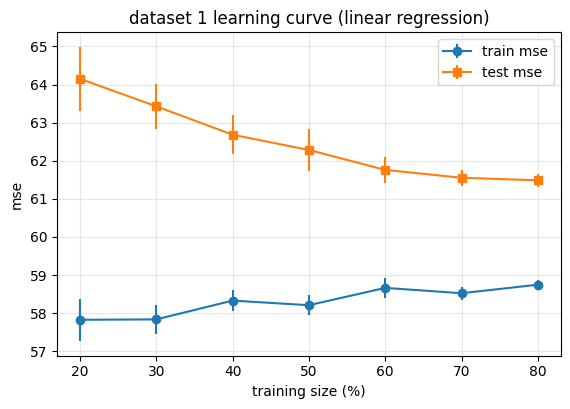

In [18]:
try:
    features_train
    targets_train
    features_test
    targets_test
except NameError:
    features_train, features_test, targets_train, targets_test = train_test_split_80_20(
        X1_mat, y1_vec, seed=0
    )

n_train = features_train.shape[0]

train_mse_means = []
train_mse_stds = []
test_mse_means = []
test_mse_stds = []

for fraction_index, fraction in enumerate(training_size_fractions):
    # compute how many samples this fraction corresponds to
    subset_count = max(1, int(round(fraction * n_train)))

    run_train_mse = []
    run_test_mse = []

    for repeat_index in range(repeats_per_size):
        # pick a fixed random subset for this run
        rng = make_rng(fraction_index, repeat_index)
        subset_idx = sample_indices(n_train, subset_count, rng)

        X_sub = features_train[subset_idx]
        y_sub = targets_train[subset_idx]

        # fit linear regression (closed-form)
        model = LinearRegression()
        model.fit(X_sub, y_sub)

        # evaluate on the subset used for training (train mse)
        y_sub_pred = model.predict(X_sub)
        run_train_mse.append(mse(y_sub, y_sub_pred))

        # evaluate on the full test set (test mse)
        y_test_pred = model.predict(features_test)
        run_test_mse.append(mse(targets_test, y_test_pred))

    train_mse_means.append(float(np.mean(run_train_mse)))
    train_mse_stds.append(float(np.std(run_train_mse)))
    test_mse_means.append(float(np.mean(run_test_mse)))
    test_mse_stds.append(float(np.std(run_test_mse)))

# plot learning curves with error bars
x_percent = [int(f * 100) for f in training_size_fractions]

use_ci = True
scale = (1.96 / np.sqrt(repeats_per_size)) if use_ci else 1.0
train_yerr = scale * np.array(train_mse_stds)
test_yerr = scale * np.array(test_mse_stds)

plt.figure(figsize=(6.5, 4.2))
plt.errorbar(x_percent, train_mse_means, yerr=train_yerr, marker="o", label="train mse")
plt.errorbar(x_percent, test_mse_means,  yerr=test_yerr,  marker="s", label="test mse")
plt.title("dataset 1 learning curve (linear regression)")
plt.xlabel("training size (%)")
plt.ylabel("mse")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

*   what the lines show: train MSE stays low and rises slightly as training size increases; test MSE decreases and then plateaus.
*   why this makes sense: more data reduces variance and improves generalization (lower test MSE), while fitting a larger, more diverse set makes it harder to keep training error as low (slight train MSE increase).

Part 3.3 - Dataset 2: Learning curves for logistic regression (full-batch sgd solution)

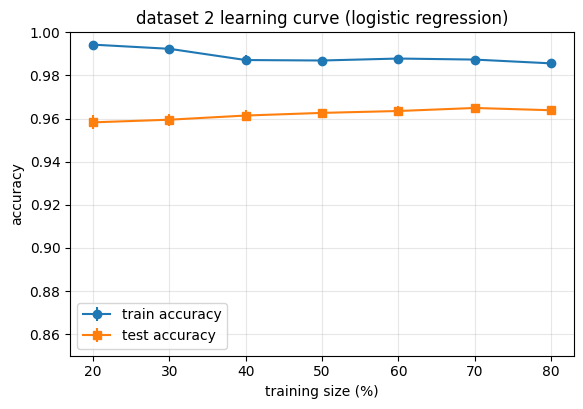

In [19]:
try:
    features_train_d2
    features_test_d2
    targets_train_d2
    targets_test_d2
    features_train_d2_std
    features_test_d2_std
except NameError:
    features_train_d2, features_test_d2, targets_train_d2, targets_test_d2 = train_test_split_80_20(
        X2_mat, y2_vec, seed=0
    )
    features_train_d2_std, features_test_d2_std = standardize_train_test(
        features_train_d2, features_test_d2
    )

n_train_d2 = features_train_d2_std.shape[0]

train_acc_means = []
train_acc_stds = []
test_acc_means = []
test_acc_stds = []

for fraction_index, fraction in enumerate(training_size_fractions):
    subset_count = max(1, int(round(fraction * n_train_d2)))

    run_train_acc = []
    run_test_acc  = []

    for repeat_index in range(repeats_per_size):
        rng = make_rng(fraction_index, repeat_index)
        subset_idx = sample_indices(n_train_d2, subset_count, rng)

        X_sub = features_train_d2_std[subset_idx]
        y_sub = targets_train_d2[subset_idx]

        model = LogisticRegressionGD(lr=0.1, epochs=300, batch_size=32)
        model.fit(X_sub, y_sub)

        y_sub_pred  = model.predict(X_sub)
        y_test_pred = model.predict(features_test_d2_std)

        run_train_acc.append(accuracy(y_sub, y_sub_pred))
        run_test_acc.append(accuracy(targets_test_d2, y_test_pred))

    train_acc_means.append(float(np.mean(run_train_acc)))
    train_acc_stds.append(float(np.std(run_train_acc)))
    test_acc_means.append(float(np.mean(run_test_acc)))
    test_acc_stds.append(float(np.std(run_test_acc)))

use_ci = True
scale = (1.96 / np.sqrt(repeats_per_size)) if use_ci else 1.0
train_yerr = scale * np.array(train_acc_stds)
test_yerr  = scale * np.array(test_acc_stds)

x_percent = [int(f * 100) for f in training_size_fractions]

plt.figure(figsize=(6.5, 4.2))
plt.errorbar(x_percent, train_acc_means, yerr=train_yerr, marker="o", label="train accuracy")
plt.errorbar(x_percent, test_acc_means,  yerr=test_yerr,  marker="s", label="test accuracy")
plt.title("dataset 2 learning curve (logistic regression)")
plt.xlabel("training size (%)")
plt.ylabel("accuracy")
plt.ylim(0.85, 1.0)
plt.legend()
plt.grid(alpha=0.3)
plt.show()

*   what the lines show: train accuracy gently decreases with more data; test accuracy starts high (~0.96 at 20%) and nudges up, then plateaus.
*   why this makes sense: the task is easy for this model; even small subsets capture enough signal (ceiling effect). More data slightly improves generalization, but gains are small once near saturation.

Part 3.4: Setup

In [24]:
batch_sizes_to_try = [2, 4, 8, 16, 32, 64, 128, 256, "full"]

linear_lr = 1e-4
logistic_lr = 1e-4
num_epochs = 300

Part 3.4 - Dataset 1: Linear regression testing various minibatch sizes vs. full-batch

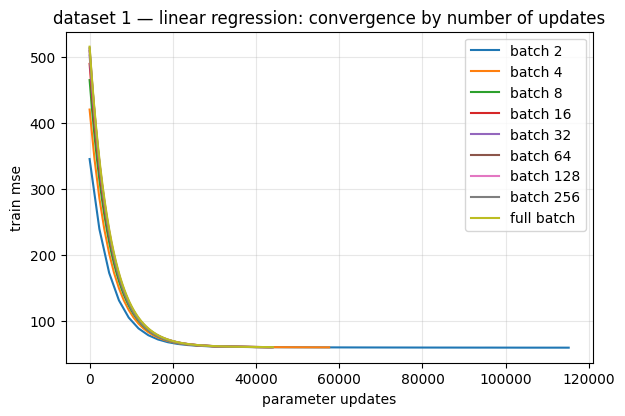

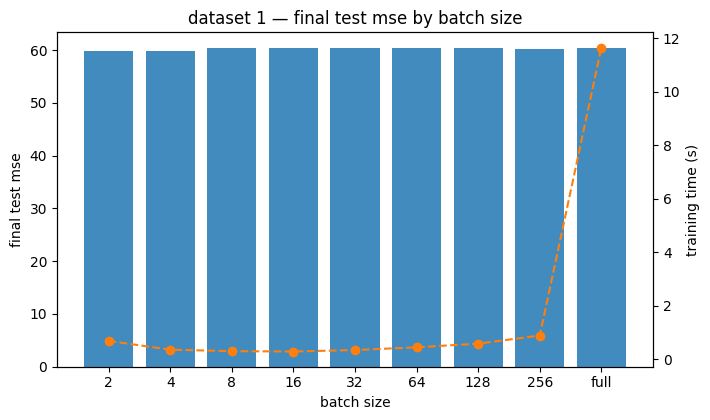

In [ ]:
try:
    features_train
    targets_train
    features_test
    targets_test
except NameError:
    features_train, features_test, targets_train, targets_test = train_test_split_80_20(
        X1_mat, y1_vec, seed=0
    )

# standardize dataset 1 features for sgd (train stats only)
X1_train_std, X1_test_std = standardize_train_test(features_train, features_test)

linear_histories = {} # batch_size -> np.array of train mse per epoch
linear_times = {} # batch_size -> wall time (s)
linear_test_mse = {} # batch_size -> final test mse

n1 = X1_train_std.shape[0]
steps_per_epoch_ref = n1 / 32.0  # reference = batch 32

for bsz in batch_sizes_to_try:
    eff = n1 if bsz == "full" else bsz
    steps_per_epoch = n1 / float(eff)
    epochs_scaled = int(round(num_epochs * (steps_per_epoch_ref / steps_per_epoch)))
    epochs_scaled = max(50, epochs_scaled)

    model = LinearRegression(lr=1e-4, epochs=epochs_scaled, batch_size=eff)

    t0 = time.perf_counter()
    model, hist = model.fit_sgd(X1_train_std, targets_train, return_history=True, seed=0)
    linear_times[bsz] = time.perf_counter() - t0

    linear_histories[bsz] = hist

    y_te_pred = model.predict(X1_test_std)
    linear_test_mse[bsz] = mse(targets_test, y_te_pred)

# plot 1: convergence vs parameter updates
plt.figure(figsize=(6.8, 4.3))
for bsz in batch_sizes_to_try:
    eff = n1 if bsz == "full" else bsz
    steps_per_epoch = n1 / float(eff)
    updates = np.arange(len(linear_histories[bsz])) * steps_per_epoch
    label = f"batch {bsz}" if bsz != "full" else "full batch"
    plt.plot(updates, linear_histories[bsz], label=label)
plt.xlabel("parameter updates")
plt.ylabel("train mse")
plt.title("dataset 1 — linear regression: convergence by number of updates")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

# plot 2: final test mse and training time
sizes = [str(b) for b in batch_sizes_to_try]
mse_vals = [linear_test_mse[b] for b in batch_sizes_to_try]
time_vals = [linear_times[b] for b in batch_sizes_to_try]

fig, ax1 = plt.subplots(figsize=(7.2, 4.3))
ax1.bar(sizes, mse_vals, alpha=0.85)
ax1.set_ylabel("final test mse")
ax1.set_xlabel("batch size")
ax1.set_title("dataset 1 — final test mse by batch size")

ax2 = ax1.twinx()
ax2.plot(sizes, time_vals, marker="o", linestyle="--", color="tab:orange")
ax2.set_ylabel("training time (s)")
ax2.grid(False)
fig.tight_layout()
plt.show()

Part 3.4 - Dataset 2: Logistic regression testing various minibatch sizes vs. full-batch

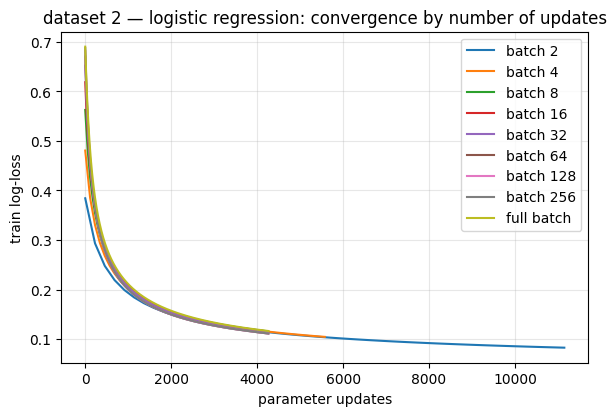

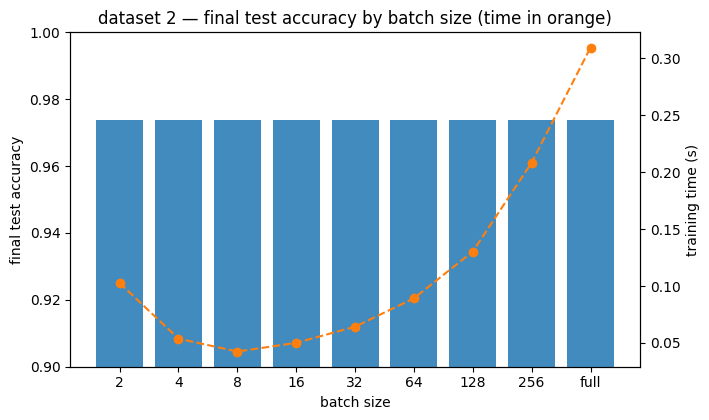

In [28]:
try:
    features_train_d2
    features_test_d2
    targets_train_d2
    targets_test_d2
except NameError:
    features_train_d2, features_test_d2, targets_train_d2, targets_test_d2 = train_test_split_80_20(
        X2_mat, y2_vec, seed=0
    )

X2_train_std, X2_test_std = standardize_train_test(features_train_d2, features_test_d2)

logistic_histories = {}  # batch_size -> np.array of train log-loss per epoch
logistic_times = {}  # batch_size -> wall time (s)
logistic_test_acc = {}  # batch_size -> final test accuracy

n2 = X2_train_std.shape[0]
steps_per_epoch_ref = n2 / 32.0  # reference = batch 32

def lr_for_logistic(bsz):
    if bsz == "full":
      return 2e-3
    if bsz == 128:
      return 5e-4
    return 1e-3

for bsz in batch_sizes_to_try:
    eff = n2 if bsz == "full" else bsz
    steps_per_epoch = n2 / float(eff)
    epochs_scaled = int(round(num_epochs * (steps_per_epoch_ref / steps_per_epoch)))
    epochs_scaled = max(50, epochs_scaled)

    model = LogisticRegressionGD(lr=1.5e-3, epochs=epochs_scaled, batch_size=eff)

    t0 = time.perf_counter()
    model, hist = model.fit_sgd(X2_train_std, targets_train_d2, return_history=True, seed=0)
    logistic_times[bsz] = time.perf_counter() - t0

    logistic_histories[bsz] = hist

    y_te_pred = model.predict(X2_test_std)
    logistic_test_acc[bsz] = float(np.mean(y_te_pred == targets_test_d2))

# plot 1: convergence vs parameter updates (train log-loss)
plt.figure(figsize=(6.8, 4.3))
for bsz in batch_sizes_to_try:
    eff = n2 if bsz == "full" else bsz
    steps_per_epoch = n2 / float(eff)
    updates = np.arange(len(logistic_histories[bsz])) * steps_per_epoch
    label = f"batch {bsz}" if bsz != "full" else "full batch"
    plt.plot(updates, logistic_histories[bsz], label=label)
plt.xlabel("parameter updates")
plt.ylabel("train log-loss")
plt.title("dataset 2 — logistic regression: convergence by number of updates")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

# plot 2: final test accuracy and training time
sizes = [str(b) for b in batch_sizes_to_try]
acc_vals  = [logistic_test_acc[b] for b in batch_sizes_to_try]
time_vals = [logistic_times[b]     for b in batch_sizes_to_try]

fig, ax1 = plt.subplots(figsize=(7.2, 4.3))
ax1.bar(sizes, acc_vals, alpha=0.85)
ax1.set_ylabel("final test accuracy")
ax1.set_xlabel("batch size")
ax1.set_ylim(0.9, 1.0) # optional zoom; adjust if needed
ax1.set_title("dataset 2 — final test accuracy by batch size (time in orange)")

ax2 = ax1.twinx()
ax2.plot(sizes, time_vals, marker="o", linestyle="--", color="tab:orange")
ax2.set_ylabel("training time (s)")
ax2.grid(False)
fig.tight_layout()
plt.show()


If we judge by generalization (test error/accuracy) + compute time, the sweet spot is a mini-batch, not full batch.

*   Recommended: batch size 8 or 16 (prefer 8) - they match the best test metrics while being much faster than full batch.

Part 3.5 - Dataset 1: Linear regression with different learning rates

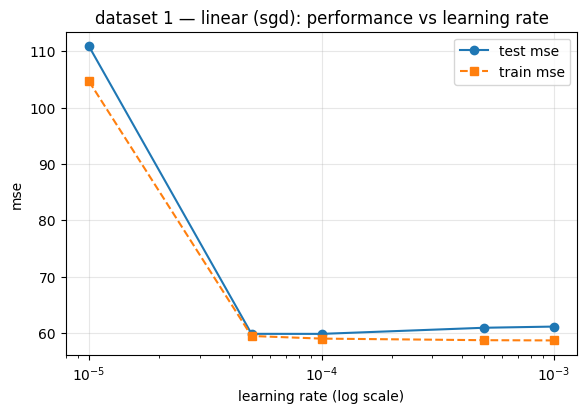

lr=1e-05     train_mse=104.63  test_mse=110.83
lr=5e-05     train_mse=59.50  test_mse=59.88
lr=0.0001    train_mse=59.03  test_mse=59.87
lr=0.0005    train_mse=58.75  test_mse=60.95
lr=0.001     train_mse=58.71  test_mse=61.16


In [29]:
try:
    features_train; features_test; targets_train; targets_test
except NameError:
    features_train, features_test, targets_train, targets_test = train_test_split_80_20(X1_mat, y1_vec, seed=0)

try:
    X1_train_std; X1_test_std
except NameError:
    X1_train_std, X1_test_std = standardize_train_test(features_train, features_test)

try:
    features_train_d2; features_test_d2; targets_train_d2; targets_test_d2
except NameError:
    features_train_d2, features_test_d2, targets_train_d2, targets_test_d2 = train_test_split_80_20(X2_mat, y2_vec, seed=0)

try:
    X2_train_std; X2_test_std
except NameError:
    X2_train_std, X2_test_std = standardize_train_test(features_train_d2, features_test_d2)

# learning rates to try (log scale spread)
learning_rates = [1e-5, 5e-5, 1e-4, 5e-4, 1e-3]

# keep batch size fixed so we isolate lr effects
batch_size_for_lr = 32

# epochs: enough for stable comparison without being too slow
epochs_for_lr = 800

# tiny helpers (reuse your mse/accuracy if already defined)
def _mse(y_true, y_pred):
      return mse(y_true, y_pred)

def _accuracy(y_true, y_pred_labels):
      return accuracy(y_true, y_pred_labels)

linear_lr_results = []

for lr in learning_rates:
    model = LinearRegression(lr=lr, epochs=epochs_for_lr, batch_size=batch_size_for_lr)
    model = model.fit_sgd(X1_train_std, targets_train, seed=0, return_history=False)

    # train predictions for train mse
    y_train_pred = model.predict(X1_train_std)
    train_mse = _mse(targets_train, y_train_pred)

    # test predictions for test mse
    y_test_pred = model.predict(X1_test_std)
    test_mse = _mse(targets_test, y_test_pred)

    linear_lr_results.append({'lr': lr, 'train_mse': train_mse, 'test_mse': test_mse})

# sort by lr for pretty plotting
linear_lr_results = sorted(linear_lr_results, key=lambda d: d['lr'])

# plot test mse vs learning rate (log x-axis)
plt.figure(figsize=(6.6, 4.2))
plt.plot([r['lr'] for r in linear_lr_results],
         [r['test_mse'] for r in linear_lr_results],
         marker='o', label='test mse')
plt.plot([r['lr'] for r in linear_lr_results],
         [r['train_mse'] for r in linear_lr_results],
         marker='s', linestyle='--', label='train mse')
plt.xscale('log')
plt.xlabel('learning rate (log scale)')
plt.ylabel('mse')
plt.title('dataset 1 — linear (sgd): performance vs learning rate')
plt.grid(alpha=0.3)
plt.legend()
plt.show()

# print a small table
for r in linear_lr_results:
    print(f"lr={r['lr']:<8g}  train_mse={r['train_mse']:.2f}  test_mse={r['test_mse']:.2f}")


Part 3.5 - Dataset 2: Logistic regression with different learning rates

lr=1e-05    train_acc=0.9363  test_acc=0.9474
lr=5e-05    train_acc=0.9385  test_acc=0.9474
lr=0.0001   train_acc=0.9516  test_acc=0.9474
lr=0.0005   train_acc=0.9714  test_acc=0.9561
lr=0.001    train_acc=0.9736  test_acc=0.9649


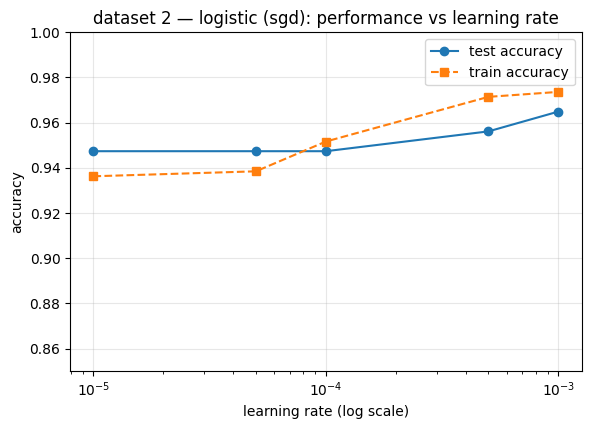

In [30]:
try:
    features_train_d2, features_test_d2, targets_train_d2, targets_test_d2
except NameError:
    features_train_d2, features_test_d2, targets_train_d2, targets_test_d2 = train_test_split_80_20(
        X2_mat, y2_vec, seed=0
    )

# standardize using train stats
X2_train_std, X2_test_std = standardize_train_test(features_train_d2, features_test_d2)

lrs = [1e-5, 5e-5, 1e-4, 5e-4, 1e-3]

train_acc, test_acc = [], []

batch_size = 32
epochs_for_sweep = num_epochs

for lr in lrs:
    # init model with the lr we are testing; reuse epochs and batch size
    log_model = LogisticRegressionGD(lr=lr, epochs=epochs_for_sweep, batch_size=batch_size)

    # train with sgd (uses model's fit_sgd; no new functions)
    log_model.fit_sgd(X2_train_std, targets_train_d2, seed=0)

    # predict probabilities -> class labels (>= 0.5 => 1)
    y_tr_prob = log_model.sigmoid(np.c_[np.ones((X2_train_std.shape[0], 1)), X2_train_std] @ log_model.weights)
    y_te_prob = log_model.sigmoid(np.c_[np.ones((X2_test_std.shape[0], 1)), X2_test_std] @ log_model.weights)
    y_tr_hat = (y_tr_prob >= 0.5).astype(int)
    y_te_hat = (y_te_prob >= 0.5).astype(int)

    # store accuracy
    train_acc.append(accuracy(targets_train_d2, y_tr_hat))
    test_acc.append(accuracy(targets_test_d2,  y_te_hat))

    # quick line so we can see the raw numbers too
    print(f"lr={lr:<7}  train_acc={train_acc[-1]:.4f}  test_acc={test_acc[-1]:.4f}")

# plot accuracy vs learning rate (log scale on x)
plt.figure(figsize=(6.6, 4.4))
plt.plot(lrs, test_acc, marker="o", label="test accuracy")
plt.plot(lrs, train_acc, marker="s", linestyle="--", label="train accuracy")
plt.xscale("log")
plt.xlabel("learning rate (log scale)")
plt.ylabel("accuracy")
plt.title("dataset 2 — logistic (sgd): performance vs learning rate")
plt.ylim(0.85, 1.0)
plt.grid(alpha=0.3)
plt.legend()
plt.show()

Part 3.6: Comparing linear regression's analytical solution vs. mini-batch

In [31]:
# analytical (closed-form) on raw features
lin_closed = LinearRegression()
lin_closed.fit(features_train, targets_train)
y_tr_hat_closed = lin_closed.predict(features_train)
y_te_hat_closed = lin_closed.predict(features_test)
mse_tr_closed = _mse(targets_train, y_tr_hat_closed)
mse_te_closed = _mse(targets_test,  y_te_hat_closed)

lin_sgd = LinearRegression(lr=1e-4, epochs=1000, batch_size=32)
lin_sgd.fit_sgd(X1_train_std, targets_train)
y_tr_hat_sgd = lin_sgd.predict(X1_train_std)
y_te_hat_sgd = lin_sgd.predict(X1_test_std)
mse_tr_sgd = _mse(targets_train, y_tr_hat_sgd)
mse_te_sgd = _mse(targets_test,  y_te_hat_sgd)

print("dataset 1 — linear regression comparison")
print(f"analytical (closed-form): train mse = {mse_tr_closed:.3f} | test mse = {mse_te_closed:.3f}")
print(f"sgd (mini-batch, std): train mse = {mse_tr_sgd:.3f} | test mse = {mse_te_sgd:.3f}")

dataset 1 — linear regression comparison
analytical (closed-form): train mse = 58.670 | test mse = 61.274
sgd (mini-batch, std): train mse = 58.948 | test mse = 60.042
